In [1]:
###### Package installations to work on WIRE

! pip install mamba
! pip install pysankey
! mamba install gensim openai -y
! mamba install -c anaconda nltk -y
! mamba install -c conda-forge spacy -y
! mamba install -c conda-forge pyldavis -y
! mamba install -c conda-forge pypdf2 -y
! pip install transformers sentence-transformers
! pip install scikit-network
! pip install git+https://github.com/rwalk/gsdmm.git

! python -m spacy download en_core_web_sm


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.3.1) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['gensim', 'openai']

conda-forge/linux-64                                        Using cache
conda-

In [2]:
# imports

import csv
import json
import os
import re
from pprint import pprint
import time
import re
import unicodedata
import openai
import os
import sys
from contextlib import contextmanager
from copy import deepcopy
import string
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import SpectralEmbedding
import pickle
import sknetwork as skn
from random import *

import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim_models
import PyPDF2

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess

import nltk
nltk.download(["names", "stopwords", "state_union", "twitter_samples", "movie_reviews", "averaged_perceptron_tagger", "vader_lexicon", "punkt", "wordnet"])
from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words("english")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
ps = nltk.porter.PorterStemmer()

from gsdmm import MovieGroupProcess

from sentence_transformers import SentenceTransformer

import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

from itertools import combinations

from scipy.spatial.distance import squareform

# set seed for reproducibility
# np.random.seed(493)

[nltk_data] Downloading package names to /home/jovyan/nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package state_union to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package state_union is already up-to-date!
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Packag

## Calculating Similarities Between Topics - Cosine similarity

In [3]:
trdf = pd.read_csv("processed_transcripts_January2020.csv")
trdf.head()

,Unnamed: 0,Transcript,Topic,Sentiment,Program
0,0,21,"['impeachment', 'word', 'election', 'evidence'...",0.060427,Fox News Network INGRAHAM ANGLE
1,1,21,"['generation', 'free', 'people', 'see', 'man',...",0.049355,Fox News Network INGRAHAM ANGLE
2,2,21,"['stage', 'mueller', 'grief', 'lie', 'come', '...",0.053714,Fox News Network INGRAHAM ANGLE
3,3,21,"['information', 'memo', 'medium', 'comey', 'mo...",-0.175079,Fox News Network INGRAHAM ANGLE
4,4,21,"['tonight', 'report', 'liberal', 'angle']",-0.251427,Fox News Network INGRAHAM ANGLE


In [4]:
topic_sentences = [' '.join(map(str, l)) for l in list(trdf['Topic'])]
embedding_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
vectors = embedding_model.encode(topic_sentences)
vectors

array([[-0.00082716,  0.0089577 , -0.00906638, ...,  0.03018118,
        -0.05595985, -0.00235308],
       [-0.03071563, -0.01422877, -0.0145195 , ...,  0.0739079 ,
        -0.02403686,  0.01844509],
       [-0.00684175, -0.01522866, -0.0097964 , ...,  0.04466537,
        -0.03457788,  0.00668371],
       ...,
       [ 0.00386021,  0.0052284 , -0.00725446, ...,  0.00145087,
        -0.04232047,  0.00411237],
       [-0.00486186,  0.0140963 , -0.0053045 , ...,  0.03236622,
        -0.04621979,  0.02572994],
       [ 0.00399684, -0.00999388, -0.01012418, ...,  0.03189504,
        -0.026596  ,  0.0037726 ]], dtype=float32)

In [5]:
csim = cosine_similarity(vectors)
print(np.quantile(csim, .25))
print(np.quantile(csim, .5))
print(np.quantile(csim, .75))
print(np.quantile(csim, 1))
hist = np.histogram(csim, bins = 50, range = (0,1))
print(hist)

0.8499558568000793
0.8882259130477905
0.9159327745437622
1.000001
(array([      0,       0,       0,       0,       0,       0,       0,
             0,       0,       0,       0,       0,       0,       4,
            22,     204,     878,    2330,    5320,    8570,   10532,
         11086,   10028,    8834,    8360,    9456,   13850,   21288,
         30172,   40558,   54742,   75716,  107402,  156222,  228216,
        327006,  455176,  630924,  885476, 1276332, 1895920, 2833020,
       4162512, 5821754, 7417328, 8050202, 6376032, 2714938,  299144,
          4353]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ], dtype=float32))


In [6]:
# Post-processesing step
csim = cosine_similarity(vectors)
csim[csim <0.25964] = 0
csim[csim >1] = 1

In [7]:
csim.shape

(6630, 6630)

In [8]:
#counting the number of nonzero results
np.count_nonzero(csim)

43956900

In [9]:
print("max cosine similarity {} and min cosine similarity {}".format(csim.max(), csim.min()))

max cosine similarity 1.0 and min cosine similarity 0.27665969729423523


## Adding Sentiment Simmilarity

In [14]:
sent = [2 - abs(i - j) for (i, j) in combinations(trdf['Sentiment'], 2)]
distance_sent = [abs(i - j) for (i, j) in combinations(trdf['Sentiment'], 2)]
m = np.mean(sent)
std = np.std(sent)
print(std)
print(m)
print(sent[0:5])
#diff = [(2 - abs(i - j) - m) / std for (i, j) in combinations(tr_tp_st[2], 2)]
sent_matrix = squareform(sent)
dist_sent_matrix = squareform(distance_sent)
print(len(sent_matrix))

0.21599306475476066
1.7297114863115994
[1.9889273877292852, 1.9932861853832442, 1.7644939775910364, 1.6881452762923352, 1.977288854489164]
6630


In [13]:
print(sent[0:5])
print(sent_matrix[0][0:5])

[1.9889273877292852, 1.9932861853832442, 1.7644939775910364, 1.6881452762923352, 1.977288854489164]
[0.         1.98892739 1.99328619 1.76449398 1.68814528]


In [17]:
sim_sent = np.multiply(csim, sent_matrix)
dist_sim_sent = np.multiply(csim, dist_sent_matrix)
print(csim[6600][500:550])
print(sent_matrix[6600][500:550])
sim_sent[6600][500:550]

[0.80219257 0.83613265 0.8199642  0.8314212  0.87347585 0.8294101
 0.8687048  0.82124865 0.9249494  0.8587235  0.85570097 0.8388941
 0.82498235 0.8432785  0.8559034  0.85943484 0.8685502  0.8497503
 0.8777907  0.85962903 0.8052634  0.81132174 0.85049653 0.88471377
 0.82245034 0.83613676 0.8098058  0.85344243 0.8356787  0.8501853
 0.83289045 0.8198942  0.83924484 0.90168923 0.7699299  0.85041666
 0.84551376 0.8552761  0.90079707 0.87282425 0.8379847  0.8411301
 0.8637572  0.8852463  0.8093345  0.7525723  0.6226373  0.8253859
 0.7703042  0.85496163]
[1.93673125 1.99868333 1.63041111 1.96595833 1.87985965 1.85336667
 1.84911667 1.83445    1.949475   1.92990488 1.95221842 1.96159583
 1.97912    1.53926136 1.73635385 1.8195     1.80955938 1.85867143
 1.80003143 1.81006667 1.87058983 1.92508367 1.4337     1.69396133
 1.95166042 1.88995172 1.63061818 1.41099286 1.83917162 1.92189355
 1.81565417 1.8416381  1.7667     1.86967951 1.915632   1.99777391
 1.98629167 1.81924    1.71976667 1.81612222

array([1.55363142, 1.67116438, 1.33687869, 1.63453943, 1.642012  ,
       1.53720099, 1.60633652, 1.50653959, 1.80316575, 1.65725471,
       1.6705152 , 1.64557123, 1.63273906, 1.29802606, 1.48615114,
       1.5637417 , 1.57169312, 1.57940657, 1.58005083, 1.55598586,
       1.50631753, 1.56186223, 1.21935688, 1.49867092, 1.60514377,
       1.58025811, 1.32048408, 1.20420117, 1.53695654, 1.6339656 ,
       1.51224102, 1.50994838, 1.48269386, 1.68586988, 1.47490233,
       1.69894022, 1.67943694, 1.55595251, 1.54916077, 1.58515552,
       1.6609    , 1.66442277, 1.6355588 , 1.7345554 , 1.44422245,
       1.48896948, 1.18080435, 1.63159711, 1.39538709, 1.39420629])

## Aggregating by Transcript and Program

In [18]:
# Creation of a transcript-to-transcript network, T, based on transcript topic similarity matrix, csim

T_network = skn.data.from_edge_list([(trdf["Transcript"][i], list(trdf.index)[i]) for i in range(len(trdf.index))], bipartite=True)
T = T_network['biadjacency']


In [19]:
T_network

{'names_row': array([   21,    36,    38, ..., 20789, 20793, 20819]),
 'names': array([   21,    36,    38, ..., 20789, 20793, 20819]),
 'biadjacency': <1402x6630 sparse matrix of type '<class 'numpy.int64'>'
 	with 6630 stored elements in Compressed Sparse Row format>}

In [20]:
transcript_sim_network = T * sim_sent * T.T
transcript_dist_network = T * dist_sim_sent * T.T

In [21]:
transcript_sim_network.shape

(1402, 1402)

In [22]:
#counting the number of nonzero results
np.count_nonzero(transcript_sim_network)

1965585

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


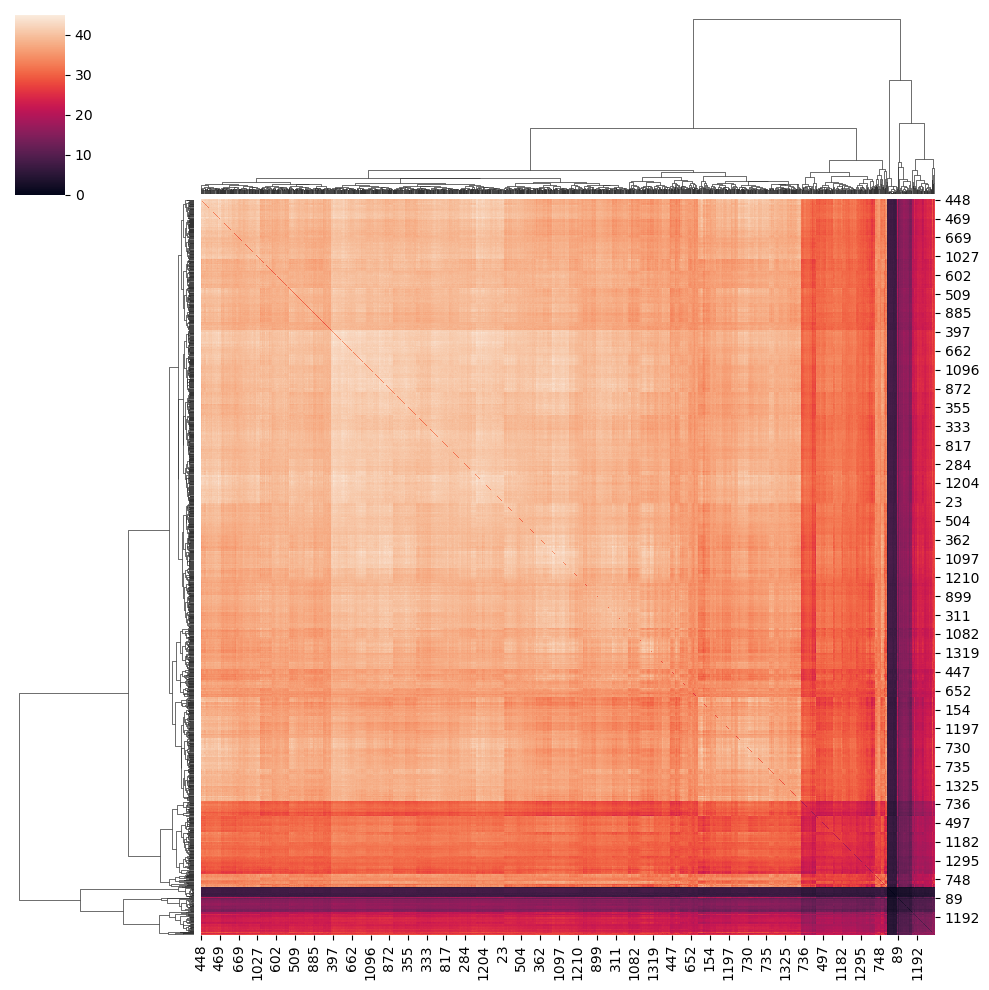

In [23]:
sns.clustermap(transcript_sim_network)

In [24]:
# Creation of a program-to-program similarity based on T and csim

P_network = skn.data.from_edge_list([(trdf["Program"][i], trdf['Transcript'][i]) for i in range(len(trdf.index))], bipartite=True, sum_duplicates=False)
P = P_network['biadjacency']

In [25]:
#weighing program-to-program similarity by number of topics
progs = trdf['Program'].unique()
print(len(progs))
prog_tops = []
for p in progs:
    tops = trdf[trdf['Program'] == p]
    prog_tops.append(1 / len(tops))
    
ptm = [i * j for (i, j) in combinations(prog_tops, 2)]
m = np.mean(ptm)
std = np.std(sent)
print(std)
print(m)
#diff = [(2 - abs(i - j) - m) / std for (i, j) in combinations(tr_tp_st[2], 2)]
ptm_matrix = squareform(ptm)
print(len(ptm_matrix))

51
0.21599306475476066
0.0010502903608160551
51


In [26]:
P_network

{'names_row': array(['CNN ANDERSON COOPER 360 DEGREES', 'CNN AT THIS HOUR',
        'CNN CNN 10', 'CNN CNN LIVE EVENT/SPECIAL', 'CNN CNN NEWSROOM',
        'CNN CNN RELIABLE SOURCES', 'CNN CNN RIGHT NOW',
        'CNN CNN Special Reports', 'CNN CNN Tonight',
        'CNN CUOMO PRIME TIME', 'CNN EARLY START',
        'CNN ERIN BURNETT OUTFRONT', 'CNN FAREED ZAKARIA GPS',
        'CNN Inside Politics', 'CNN New Day', 'CNN New Day Saturday',
        'CNN New Day Sunday', 'CNN S.E. CUPP UNFILTERED',
        'CNN STATE OF THE UNION', 'CNN Smerconish',
        'CNN THE SITUATION ROOM', 'CNN The Lead with Jake Tapper',
        'Fox News Network FOX AND FRIENDS', 'Fox News Network FOX HANNITY',
        'Fox News Network FOX NEWS @ NIGHT',
        'Fox News Network FOX NEWS SUNDAY',
        'Fox News Network FOX SPECIAL REPORT WITH BRET BAIER',
        'Fox News Network INGRAHAM ANGLE',
        'Fox News Network JUSTICE WITH JUDGE PIRRO',
        'Fox News Network LIFE LIBERTY LEVIN',
        '

In [27]:
program_sim_network = np.multiply(P * transcript_sim_network * P.T, ptm_matrix)
program_dist_network = np.multiply(P * transcript_dist_network * P.T, ptm_matrix)

/opt/conda/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


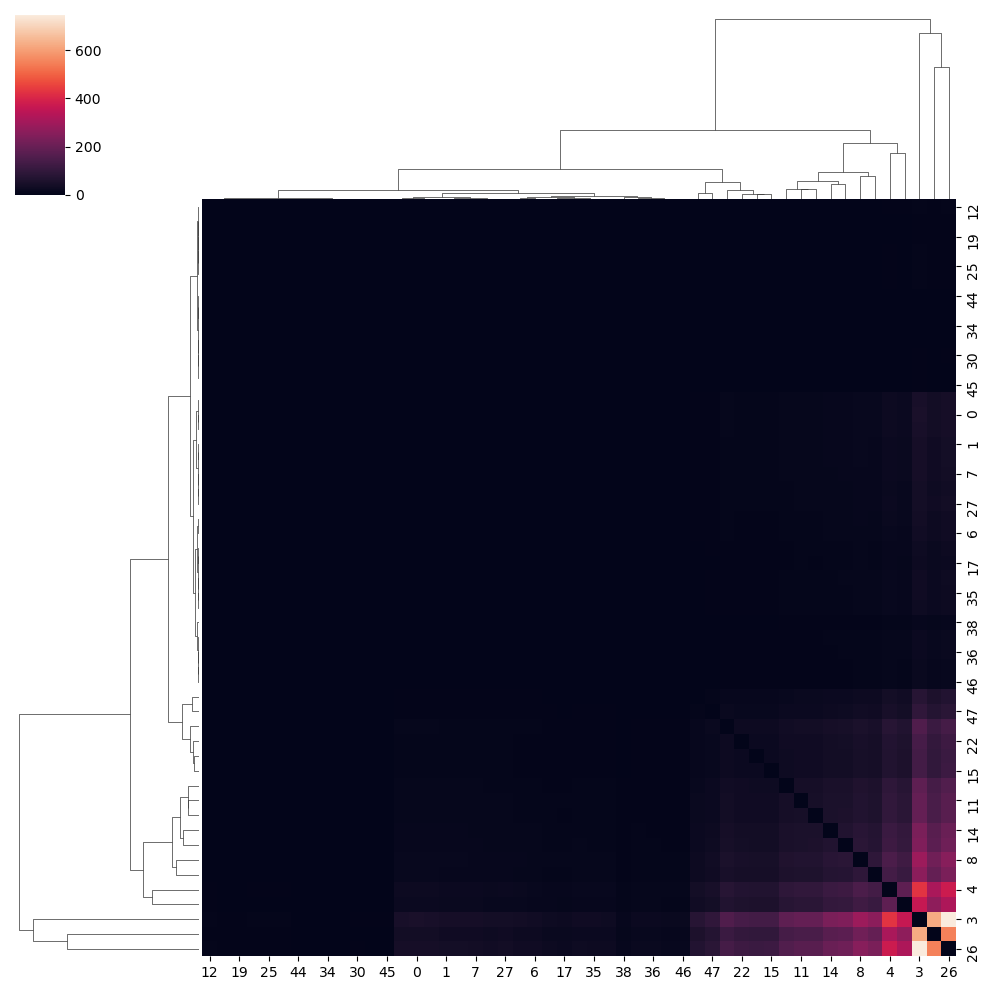

In [28]:
sns.clustermap(program_sim_network)

In [29]:
program_sim_network.shape

(51, 51)

In [30]:
program_sim_network.max()

744.9743460808363

In [31]:
network_embedding = SpectralEmbedding(affinity='precomputed')
pos_program_embeddings = network_embedding.fit_transform(program_sim_network/program_sim_network.max())

In [32]:
program_df = pd.DataFrame()
program_df['program'] = P_network['names_row']
program_df['network'] = program_df['program'].apply(lambda x: x.split()[0])
program_df['x_pos'] = pos_program_embeddings[:,0]
program_df['y_pos'] = pos_program_embeddings[:,1]

<Axes: xlabel='x_pos', ylabel='y_pos'>

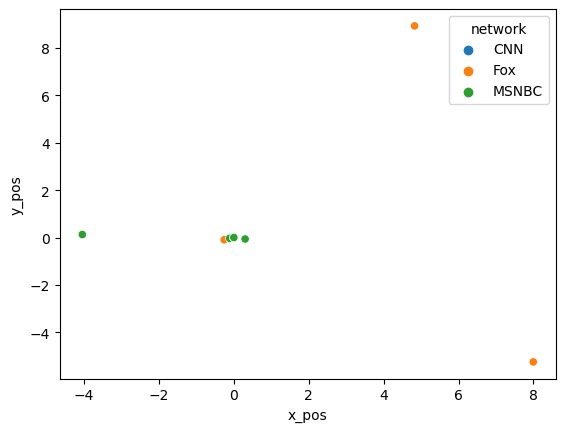

In [33]:
sns.scatterplot(data=program_df, x='x_pos', y='y_pos', hue='network')

In [34]:
from sklearn.cluster import SpectralClustering
spec_cl = SpectralClustering(
    n_clusters=3,  
    n_neighbors=20, 
    affinity='precomputed')
cluster = spec_cl.fit_predict(program_sim_network)
print(cluster)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [79]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3) 
kmeans.fit(program_sim_network)
cluster = kmeans.predict(program_sim_network)
print(cluster)

[0 0 0 1 2 0 0 0 2 2 2 2 0 2 2 2 0 0 0 0 1 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 2 2 2]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [61]:
from sklearn.cluster import AgglomerativeClustering
#dist_net = squareform(program_dist_network)
clustering = AgglomerativeClustering(n_clusters = 2).fit(program_dist_network)
print(clustering.labels_)
#sim_net = squareform(program_sim_network)
clustering = AgglomerativeClustering(n_clusters = 2).fit(program_sim_network)
clustering.labels_

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


/opt/conda/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/opt/conda/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0])

In [78]:
from sknetwork.clustering import Louvain
louvain = Louvain()
louvain = louvain.fit(program_sim_network)
print(louvain.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [47]:

def get_clusters(trdf):
    #topic simmilarity
    topic_sentences = [' '.join(map(str, l)) for l in list(trdf['Topic'])]
    embedding_model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    vectors = embedding_model.encode(topic_sentences)
    csim = cosine_similarity(vectors)
    csim[csim <0.25964] = 0
    csim[csim >1] = 1
    print('topic done')
    
    #sentiment distance
    sent = [abs(i - j) for (i, j) in combinations(trdf['Sentiment'], 2)]
    sent_matrix = squareform(sent)
    sim_sent = np.multiply(csim, sent_matrix)
    print('sentiment done')
    
    #aggregating by transcript and program
    T_network = skn.data.from_edge_list([(trdf["Transcript"][i], list(trdf.index)[i]) for i in range(len(trdf.index))], bipartite=True)
    T = T_network['biadjacency']
    transcript_sim_network = T * sim_sent * T.T
    
    P_network = skn.data.from_edge_list([(trdf["Program"][i], trdf['Transcript'][i]) for i in range(len(trdf.index))], bipartite=True, sum_duplicates=False)
    P = P_network['biadjacency']
    progs = trdf['Program'].unique()
    prog_tops = []
    for p in progs:
        tops = trdf[trdf['Program'] == p]
        prog_tops.append(1 / len(tops))
    ptm = [i * j for (i, j) in combinations(prog_tops, 2)]
    ptm_matrix = squareform(ptm)
    program_sim_network = np.multiply(P * transcript_sim_network * P.T, ptm_matrix)
    print('aggregating done')
    #clustering
    clustering = AgglomerativeClustering(n_clusters = 3).fit(program_sim_network)
    clust_df = pd.DataFrame(list(zip(progs, list(clustering.labels_))),
               columns =['Program', 'Cluster'])
    return clust_df

In [48]:
data = ['processed_transcripts_January2020.csv','processed_transcripts_February2020.csv',
        'processed_transcripts_March2020.csv','processed_transcripts_April2020.csv']
for i in range(len(data)):
    trdf = pd.read_csv(data[i])
    clust_df = get_clusters(trdf)
    clust_df = clust_df.rename(columns={'Cluster': 'Cluster_' + str(i)})
    if i == 0:
        clusters_df = clust_df
    else:
        clusters_df = clusters_df.merge(clust_df, on = 'Program', how = 'left')
    print(clusters_df)

topic done
sentiment done
aggregating done


/opt/conda/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


                                              Program  Cluster_0
0                     Fox News Network INGRAHAM ANGLE          2
1   Fox News Network FOX SPECIAL REPORT WITH BRET ...          2
2                           Fox News Network THE FIVE          2
3                         Fox News Network LIVE EVENT          0
..                                                ...        ...
47                                     CNN Smerconish          1
48                             CNN STATE OF THE UNION          1
49                           CNN CNN RELIABLE SOURCES          1
50                           CNN S.E. CUPP UNFILTERED          1

[51 rows x 2 columns]
topic done
sentiment done
aggregating done


/opt/conda/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


                                              Program  Cluster_1
0                        Fox News Network FOX HANNITY          1
1    Fox News Network THE STORY WITH MARTHA MACCALLUM          1
2                           Fox News Network THE FIVE          1
3   Fox News Network FOX SPECIAL REPORT WITH BRET ...          2
..                                                ...        ...
46                                 CNN New Day Sunday          2
47                               CNN New Day Saturday          1
48                           CNN CNN RELIABLE SOURCES          2
49                           CNN S.E. CUPP UNFILTERED          0

[50 rows x 2 columns]
topic done
sentiment done
aggregating done


/opt/conda/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


                                             Program  Cluster_2
0                    Fox News Network INGRAHAM ANGLE          1
1                          Fox News Network THE FIVE          1
2   Fox News Network THE STORY WITH MARTHA MACCALLUM          1
3            Fox News Network TUCKER CARLSON TONIGHT          1
..                                               ...        ...
46                            CNN STATE OF THE UNION          1
47                            CNN FAREED ZAKARIA GPS          1
48                           CNN CNN Special Reports          0
49                          CNN S.E. CUPP UNFILTERED          1

[50 rows x 2 columns]
topic done
sentiment done
aggregating done


/opt/conda/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


                                         Program  Cluster_3
0              Fox News Network FOX NEWS @ NIGHT          0
1   Fox News Network YOUR WORLD WITH NEIL CAVUTO          0
2                      Fox News Network THE FIVE          0
3                   Fox News Network FOX HANNITY          1
..                                           ...        ...
42                          CNN New Day Saturday          0
43                           CNN Inside Politics          0
44                       CNN CNN Special Reports          1
45                        CNN FAREED ZAKARIA GPS          0

[46 rows x 2 columns]


In [49]:
print(clusters_df)
sankey_df = clusters_df.dropna()
print(sankey_df)

                                              Program  Cluster_0  Cluster_1  \
0                     Fox News Network INGRAHAM ANGLE          2          1   
1   Fox News Network FOX SPECIAL REPORT WITH BRET ...          2          2   
2                           Fox News Network THE FIVE          2          1   
3                         Fox News Network LIVE EVENT          0          0   
..                                                ...        ...        ...   
40                    CNN ANDERSON COOPER 360 DEGREES          2          1   
41                                     CNN Smerconish          1          2   
42                             CNN STATE OF THE UNION          1          2   
43                           CNN CNN RELIABLE SOURCES          1          2   

    Cluster_2  Cluster_3  
0           1          0  
1           1          0  
2           1          0  
3           0          0  
..        ...        ...  
40          1          0  
41          0       

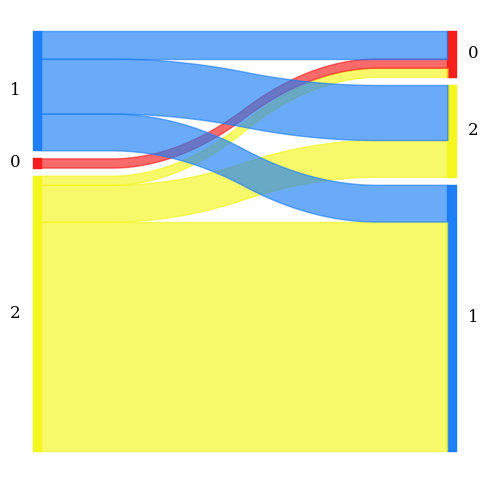

In [58]:
from pySankey.sankey import sankey

pd.options.display.max_rows = 8

colorDict = {
    0:'#f71b1b',
    1:'#1b7ef7',
    2:'#f3f71b'
}
sankey(
    sankey_df['Cluster_0'],sankey_df['Cluster_1'], aspect=20, colorDict=colorDict,
    fontsize=12
)

## Plotting programs (M2) with a bunch of manifold learning methods
### Plot color is program channel
Plot code pulled from here: https://scikit-learn.org/stable/auto_examples/manifold/plot_manifold_sphere.html#sphx-glr-auto-examples-manifold-plot-manifold-sphere-py

In [ ]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

# Variables for manifold learning.
n_neighbors = 6
n_samples = 51

# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle(
    "Manifold Learning with %i points, %i neighbors" % (51, n_neighbors), fontsize=14
)

#colors just a list of program channels for use in graphs
colors = []
for p in progs:
    if 'CNN' in p:
        colors.append(0)
    elif 'MSNBC' in p:
        colors.append(-1)
    elif 'Fox' in p:
        colors.append(1)
    else:
        print('ah')

#colors = colors[:1340]

sphere_data = program_sim_network

# Perform Locally Linear Embedding Manifold learning
methods = ["standard", "ltsa", "hessian", "modified"]
labels = ["LLE", "LTSA", "Hessian LLE", "Modified LLE"]

for i, method in enumerate(methods):
    t0 = time()
    trans_data = (
        manifold.LocallyLinearEmbedding(
            n_neighbors=n_neighbors, n_components=2, method=method
        )
        .fit_transform(sphere_data)
        .T
    )
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis("tight")

# Perform Isomap Manifold learning.
t0 = time()
trans_data = (
    manifold.Isomap(n_neighbors=n_neighbors, n_components=2)
    .fit_transform(sphere_data)
    .T
)
t1 = time()
print("%s: %.2g sec" % ("ISO", t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("%s (%.2g sec)" % ("Isomap", t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1, normalized_stress="auto")
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2, n_neighbors=n_neighbors)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis("tight")

plt.show()